In [1]:
from collections import Counter
from dataclasses import dataclass
import random
from typing import List, Dict, Tuple

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from sklearn.decomposition import PCA
import torch
from torch import nn
import torch.multiprocessing
from torch.utils.data import DataLoader, Dataset
import tqdm

from tabml.utils import embedding


GLOBAL_SEED = 42  # number of life
torch.manual_seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)

In [2]:
# TODO: use the github link
instacart_path = (
    "https://media.githubusercontent.com/media/tiepvupsu/tabml_data/master/instacart/"
)

order_df = pd.read_csv(instacart_path + "order_products__train.csv")
# order_df = pd.read_csv("order_products__train.csv")
print(order_df.info())
order_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype
---  ------             --------------    -----
 0   order_id           1384617 non-null  int64
 1   product_id         1384617 non-null  int64
 2   add_to_cart_order  1384617 non-null  int64
 3   reordered          1384617 non-null  int64
dtypes: int64(4)
memory usage: 42.3 MB
None


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [3]:
def get_list_orders(order_df: pd.DataFrame) -> List[List[int]]:
    order_df = order_df.sort_values(by=["order_id", "add_to_cart_order"])
    return order_df.groupby("order_id")["product_id"].apply(list).tolist()

all_orders = get_list_orders(order_df)
print(f"Number of orders: {len(all_orders)}")
print(f"First 3 orders: {all_orders[:3]}")

Number of orders: 131209
First 3 orders: [[49302, 11109, 10246, 49683, 43633, 13176, 47209, 22035], [39612, 19660, 49235, 43086, 46620, 34497, 48679, 46979], [11913, 18159, 4461, 21616, 23622, 32433, 28842, 42625, 39693]]


In [4]:
min_product_per_order = 2
orders = [order for order in all_orders if len(order) >= min_product_per_order]
print(f"Number of orders with at least {min_product_per_order} products: {len(orders)}")

Number of orders with at least 2 products: 124364


In [5]:
product_df = pd.read_csv(
    instacart_path + "products.csv", usecols=["product_id", "product_name"]
)
product_df.head(5)

,product_id,product_name
0,1,Chocolate Sandwich Cookies
1,2,All-Seasons Salt
2,3,Robust Golden Unsweetened Oolong Tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...
4,5,Green Chile Anytime Sauce


In [6]:
# creat a mapping between product_id and product_naem
product_name_by_id = product_df.set_index('product_id').to_dict()['product_name']
print(f"Number of product: {len(product_name_by_id)}")
print(list(product_name_by_id.items())[:5])

Number of product: 49688
[(1, 'Chocolate Sandwich Cookies'), (2, 'All-Seasons Salt'), (3, 'Robust Golden Unsweetened Oolong Tea'), (4, 'Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce'), (5, 'Green Chile Anytime Sauce')]


In [7]:
# All products appearing in orders
ordered_products = set([product for order in orders for product in order])
product_mapping = dict()
# build mappings: product_id -> product name, product_id -> product_index, product_index -> product_name
product_mapping["name_by_id"] = dict()
product_mapping["index_by_id"] = dict()
product_mapping["name_by_index"] = dict()
ind = 0
for ind, product_id in enumerate(ordered_products):
    product_name = product_name_by_id[product_id]
#     product_mapping["name_by_id"][product_id] = product_name # unused?
    product_mapping["index_by_id"][product_id] = ind
    product_mapping["name_by_index"][ind] = product_name

In [8]:
indexed_orders = [
    [product_mapping["index_by_id"][product_id] for product_id in order]
    for order in orders
]

In [9]:
context_window = 5
# total number of context products, including positive and negative products
all_targets = []
all_positive_contexts = []
for order in tqdm.tqdm(indexed_orders):
    for i, product in enumerate(order):
        all_targets.append(product)
        positive_context = [
            order[j]
            for j in range(
                max(0, i - context_window), min(len(order), i + context_window + 1)
            )
            if j != i
        ]
        all_positive_contexts.append(positive_context)

print("Sample order:", indexed_orders[0])
for i in range(3):
    print(f"Target product: {all_targets[i]}", end = ", ")
    print(f"Positive context products: {all_positive_contexts[i]}")

  0%|          | 0/124364 [00:00<?, ?it/s]

  6%|▋         | 8005/124364 [00:00<00:02, 42683.73it/s]

 14%|█▎        | 16918/124364 [00:00<00:01, 62763.09it/s]

 19%|█▉        | 23918/124364 [00:00<00:02, 48832.24it/s]

 27%|██▋       | 32982/124364 [00:00<00:01, 60914.67it/s]

 32%|███▏      | 39883/124364 [00:00<00:01, 48776.73it/s]

 39%|███▉      | 48987/124364 [00:00<00:01, 59064.07it/s]

 45%|████▍     | 55809/124364 [00:01<00:01, 47979.44it/s]

 52%|█████▏    | 64770/124364 [00:01<00:01, 57285.31it/s]

 59%|█████▉    | 73741/124364 [00:01<00:00, 65133.09it/s]

 65%|██████▌   | 81159/124364 [00:01<00:00, 48442.30it/s]

 72%|███████▏  | 90066/124364 [00:01<00:00, 56916.05it/s]

 80%|███████▉  | 99028/124364 [00:01<00:00, 64422.74it/s]

 87%|████████▋ | 107755/124364 [00:01<00:00, 70060.94it/s]

 93%|█████████▎| 115651/124364 [00:02<00:00, 50113.30it/s]

100%|██████████| 124364/124364 [00:02<00:00, 56285.48it/s]

Sample order: [38764, 8736, 8063, 39057, 34290, 10349, 37106, 17371]
Target product: 38764, Positive context products: [8736, 8063, 39057, 34290, 10349]
Target product: 8736, Positive context products: [38764, 8063, 39057, 34290, 10349, 37106]
Target product: 8063, Positive context products: [38764, 8736, 39057, 34290, 10349, 37106, 17371]


In [10]:
def get_sampling_weights(orders):
    product_freq = Counter([product for order in orders for product in order])
    sampling_weights = [0 for _ in product_freq]
    for product_index, count in product_freq.items():
        sampling_weights[product_index] = count**0.1
    return sampling_weights

sampling_weights = get_sampling_weights(indexed_orders)

In [11]:
class ProductSampler:
    def __init__(self, products, weights, pre_drawn=10_000_000):
        self.products = products
        self.weights = weights
        self.pre_drawn = pre_drawn
        self.pre_drawn_products = []

    def refill(self):
        self.pre_drawn_products = random.choices(
            population=self.products, weights=self.weights, k=self.pre_drawn
        )

    def draw(self):
        if not self.pre_drawn_products:
            self.refill()
        return self.pre_drawn_products.pop()


num_products = len(ordered_products)
product_sampler = ProductSampler(
    products=range(num_products),
    weights=sampling_weights,
    pre_drawn=10_000_000,
)

print("Sampling samples:", [product_sampler.draw() for _ in range(10)])

Sampling samples: [18012, 15194, 20128, 23857, 38659, 28964, 34018, 18115, 24862, 17684]


In [12]:
@dataclass
class TargetContextDataset(Dataset):
    all_targets: List[int]
    all_positive_contexts: List[List[int]]
    product_sampler: ProductSampler
    num_context_products: int = 10

    def __len__(self):
        return len(self.all_targets)

    def __getitem__(self, index):
        target = torch.IntTensor([self.all_targets[index]])
        positive_contexts = self.all_positive_contexts[index].copy()
        num_pos = len(positive_contexts)
        num_neg = self.num_context_products - len(positive_contexts)
        mask = [1] * num_pos + [0] * num_neg
        while len(positive_contexts) < self.num_context_products:
            product = self.product_sampler.draw()
            if product not in positive_contexts:
                positive_contexts.append(product)

        contexts = torch.IntTensor(positive_contexts)
        mask = torch.FloatTensor(mask)
        return target, contexts, mask


training_data = TargetContextDataset(
    all_targets, all_positive_contexts, product_sampler, num_context_products=10
)
train_dataloader = DataLoader(
    training_data, batch_size=8192, shuffle=True, num_workers=12
)

for target, context_products, labels in train_dataloader:
    print("Target:", target[0])
    print("Context products:", context_products[0])
    print("Labels:", labels[0])
    break

Target: tensor([9051], dtype=torch.int32)
Context products: tensor([31900, 23881, 19543, 21892, 25831, 21996, 34703, 10974, 15852, 17882],
       dtype=torch.int32)
Labels: tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.])


In [13]:
class SigmoidBCELoss(nn.Module):
    "BCEWithLogitLoss with masking on call."

    def __init__(self):
        super().__init__()

    def forward(self, inputs, label):
        inputs = torch.reshape(inputs, (inputs.shape[0], -1))
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, label, reduction="none")

        return torch.mean(out)

loss_fn = SigmoidBCELoss()
sample_logits = torch.Tensor([[100, -100], [1, 1]])
sample_labels = torch.Tensor([[1, 0], [1, 0]])
loss_fn(sample_logits, sample_labels)

tensor(0.4066)

In [14]:
class Prod2VecModel(pl.LightningModule):
    def __init__(self, num_products, embed_size: int = 50):
        super().__init__()
        self.embed_size = embed_size
        self.embed_t = nn.Embedding(num_products, self.embed_size)
        self.embed_c = nn.Embedding(num_products, self.embed_size)

    def forward(self, targets, contexts):
        v = self.embed_t(targets)
        u = self.embed_c(contexts)
        pred = torch.bmm(v, u.permute(0, 2, 1))
        return pred

    def training_step(self, batch, batch_idx):
        targets, contexts, labels = batch
        output = self.forward(targets, contexts)
        loss = loss_fn(output, labels)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=5e-3)
        return optimizer

In [15]:
embed_size = 100
model = Prod2VecModel(num_products, embed_size)
trainer = pl.Trainer(gpus=1, max_epochs=1)
trainer.fit(model, train_dataloader, train_dataloader)

GPU available: True, used: True


TPU available: False, using: 0 TPU cores


/home/tiepvu/w/tabml_book/tabml_book_env/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name    | Type      | Params
--------------------------------------
0 | embed_t | Embedding | 3.9 M 
1 | embed_c | Embedding | 3.9 M 
--------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.249    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [16]:
embs_arr = model.state_dict()['embed_t.weight'].detach().numpy()

emb_nn = embedding.NearestNeighbor(embs_arr, measure="cosine")
names = list(product_mapping["name_by_index"].values())

sub_name = "Organic Yogurt"
ids = [ind for ind in range(len(names)) if sub_name in names[ind]]
for ind in ids[:5]:
    print('==========')
    print(f'Similar items of "{names[ind]}":')
    nearest_ids = emb_nn.find_nearest_neighbors(embs_arr[ind, :], k=2)
    print([names[ind] for ind in nearest_ids])

Similar items of "Organic Yogurt Baby Food":
['Organic Yogurt Baby Food', 'Organic Wise Punkin Level 2 Baby Food']
Similar items of "Banana & Mango Organic Yogurt & Fruit Snacks ":
['Banana & Mango Organic Yogurt & Fruit Snacks\xa0', 'Quick 1 Minute Whole Grain Oats']
Similar items of "Organic Yogurt Original Plain":
['Organic Yogurt Original Plain', 'Scented Oil Life Scents Paradise Retreat']
Similar items of "Fat Free Smooth & Creamy Plain Organic Yogurt":
['Fat Free Smooth & Creamy Plain Organic Yogurt', 'Organic Greek Nonfat Yogurt With Mixed Berries']
Similar items of "Cream on Top Strawberry Organic Yogurt":
['Cream on Top Strawberry Organic Yogurt', 'Whole Oregano']


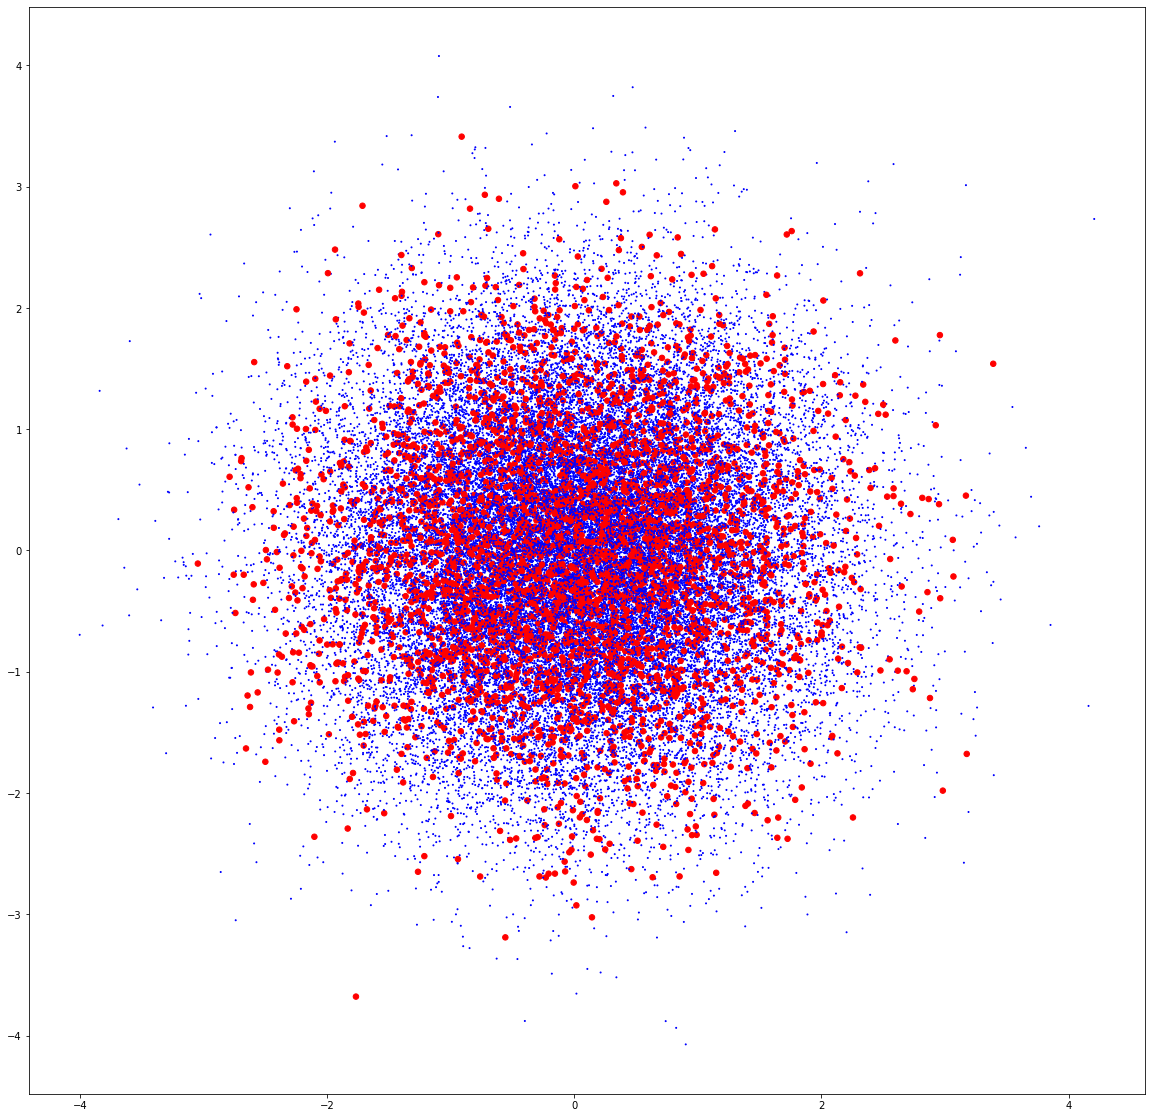

In [17]:
X2 = PCA(n_components=2).fit_transform(embs_arr)
plt.figure(figsize=(20, 20))
colors = ['b'] * num_products
s = [1] * num_products
for i, product in product_mapping["name_by_index"].items():
    if "Organic" in product:
        colors[i] = 'r'
        s[i] = 30
plt.scatter(X2[:,0], X2[:,1], c=colors, s=s)

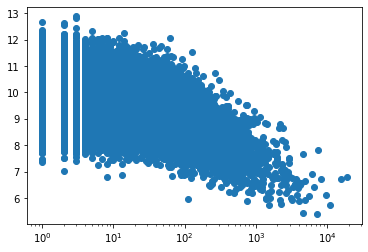

In [18]:
norm = np.sqrt((embs_arr**2).sum(axis=1))

product_freq = Counter([product for order in indexed_orders for product in order])
freqs = [0]*len(product_freq)
for product_index, freq in product_freq.items():
    freqs[product_index] = freq

fig = plt.figure()
ax = plt.gca()
ax.scatter(freqs , norm)
ax.set_xscale('log')